# MIE524 - Assignment 3
Please complete this notebook for Assignment 3.

## Q2 - Locality-Sensitive Hashing for Approximate Nearest Neighbour

In [23]:
import numpy as np
import random
import time
import unittest
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import defaultdict
import matplotlib.pyplot as plt


In [24]:
def l1(u, v):
    """
    Finds the L1 distance between two vectors
    u and v are 1-dimensional np.array objects
    """

    # TODO: Implement this
    #Assuming u & v are numpy array
    diff = abs(u-v)
    return np.sum(diff)

In [44]:
class my_LSH:
    def __init__(self, dataset, n_bands, n_rows):
        """
        Initializes the LSH object
        dataset - dataset to be searched
        n_bands - number of bands
        n_rows - number of rows in each band
        """
        self.n_bands =  n_bands
        self.n_rows =  n_rows

        self.A  =  dataset
        self.bands  =  self.create_bands()
        self.bands_buckets = [defaultdict(set) for band in self.bands]
        self.index_data()

    def create_band_function(self, dimensions, thresholds):
        """
        Creates a g_j function from the original image and compare from a list of dimensions and thresholds.
        Each g_j function generates the j'th band values for a given datapoint (a concatenation of r hash values).
        Each (locality-sensitive) hash value is equal 1 if the corresponding dimension in the original image is higher than the corresppnding threshold.
        """
        def band_function(v):
            boolarray = [v[dimensions[i]] >= thresholds[i] for i in range(len(dimensions))]
            return "".join(map(str, map(int, boolarray)))
        return band_function

    def create_bands(self, num_dimensions=400, min_threshold=0, max_threshold=255):
        """
        Creates the collection of g_j functions 1<=j<=b, one for each band.
        Each function selects r dimensions (i.e. column indices of the image matrix)
        at random, and then chooses a random threshold for each dimension, between 0 and
        255.  For any image, if its value on a given dimension is greater than or equal to
        the randomly chosen threshold, we set that bit to 1.  Each hash function returns
        a length-r bit string of the form "0101010001101001...".
        """
        bands = []
        for i in range(self.n_bands):
            dimensions = np.random.randint(low = 0,
                                        high = num_dimensions,
                                        size = self.n_rows)
            thresholds = np.random.randint(low = min_threshold,
                                        high = max_threshold + 1,
                                        size = self.n_rows)

            bands.append(self.create_band_function(dimensions, thresholds))
        return bands

    def hash_vector(self, v):
        """
        Hashes an individual vector (i.e. image).  This produces an array with b
        entries (one for each band), where each entry is a string of r bits (one for each row).
        """
        return [f(v) for f in self.bands]

    def index_data(self):
        """
        Hashes the data in A, where each row is a datapoint, using the b band
        functions in "functions." For each band, we use the corresponding dictionary (hash table) to index the data point.
        """
        for doc_index in range(self.A.shape[0]):
            doc_hash = self.hash_vector(self.A[doc_index,:])
            for band_idx, doc_band_hash in enumerate(doc_hash):
                self.bands_buckets[band_idx][doc_band_hash].add(doc_index)

    def get_candidates(self, query_vector):
        """
        Retrieve all of the points that hash to one of the same buckets as the query point.
        """
        query_hash = self.hash_vector(query_vector)
        candidates = set()
        for band_idx, query_band_hash in enumerate(query_hash):
          bucket_candidates = self.bands_buckets[band_idx][query_band_hash]
          candidates = candidates.union(bucket_candidates)
        return candidates

    def lsh_search(self, query_vector , num_neighbours=10):
        """
        Run the entire LSH algorithm
        """
        # 1. Get the candidates for nearest neighbours
        # 2. Determine distance of candidates
        # 3. Extract best neighbours
        # 4. Return a list of the best neighbours and a list of the corresponding distances between each neighbour and the query

        # TODO: YOUR CODE HERE
        candidates = self.get_candidates(query_vector)
        d = dict()
        for candidate in candidates:
          d[candidate] = l1(query_vector,self.A[candidate,:]) #Keep the L1 distance as a value in dict d
        sorted_dict = dict(sorted(d.items(), key=lambda item: item[1])) #Sort by value (L1 distance) in ascending order
        lsh_neighbours = list(sorted_dict.keys())[:num_neighbours] #Keep only the best neighbours, corresponding to num_neighbours
        lsh_dist = list(sorted_dict.values())[:num_neighbours] #Keep the distance of those neighbours
        return lsh_neighbours, lsh_dist

In [26]:
def plot(A, row_nums, base_filename):
    """
    Plots images at the specified rows and saves them each to files.
    """
    for row_num in row_nums:
        patch = np.reshape(A[row_num, :], [20, 20])
        im = Image.fromarray(patch)
        if im.mode != 'RGB':
            im = im.convert('RGB')
        display(im)
        im.save(base_filename + "-" + str(row_num) + ".png")

In [27]:
#### TESTS #####

class TestLSH(unittest.TestCase):
    def test_l1(self):
        u = np.array([1, 2, 3, 4])
        v = np.array([2, 3, 2, 3])
        self.assertEqual(l1(u, v), 4)

    def test_hash_data(self):
        f1 = lambda v: sum(v)
        f2 = lambda v: sum([x * x for x in v])
        A = np.array([[1, 2, 3], [4, 5, 6]])
        self.assertEqual(f1(A[0,:]), 6)
        self.assertEqual(f2(A[0,:]), 14)

        functions = [f1, f2]
        self.assertTrue(np.array_equal(lsh.hash_vector(functions, A[0, :]), np.array([6, 14])))
        self.assertTrue(np.array_equal(lsh.hash_data(functions, A), np.array([[6, 14], [15, 77]])))

    ### You may write your own tests here


### b) Split data with 100 random query points

In [28]:
data = np.genfromtxt('patches.csv', delimiter=',')
dataset, query_points = train_test_split(data, test_size=100, random_state=42)

### c) Compare LSH and linear search for the 100 query points

In [29]:
# Initialize a my_LSH class
lsh = my_LSH(dataset , n_rows=24 , n_bands=10 )

In [30]:
def linear_search(A, query_vector, num_neighbours):
    """
    Finds the nearest neighbours to a given vector, using linear search.
    """
    # TODO: YOUR CODE HERE
    d = dict()
    for i in range(A.shape[0]): #same method as lsh_search but done on all images in A
      d[i] = l1(query_vector, A[i,:])
    sorted_dict = dict(sorted(d.items(), key=lambda item: item[1]))
    linear_search_neighbours = list(sorted_dict.keys())[:num_neighbours]
    linear_search_distance = list(sorted_dict.values())[:num_neighbours]

    return linear_search_neighbours, linear_search_distance

In [31]:
# TODO: YOUR CODE HERE
#Keep top3 and their distances
top3_linear = []
top3_lsh = []

#Keep only distances
lsh_dist = []
linear_dist = []

start_linear = time.time()
for i in range(query_points.shape[0]):
  query_vector = query_points[i,:]
  lin = linear_search(dataset,query_vector,3)
  top3_linear.append(lin)
  linear_dist.append(lin[1])
end_linear = time.time()

start_lsh = time.time()
for i in range(query_points.shape[0]):
  query_vector = query_points[i,:]
  l = lsh.lsh_search(query_vector, num_neighbours=3)
  top3_lsh.append(l)
  lsh_dist.append(l[1])
end_lsh = time.time()

print(f"Top3s of all query from Linear search: {top3_linear}")
print(f"Top3s of all query from LSH: {top3_lsh}")
print(f"Average search time for Linear search: {end_linear-start_linear}")
print(f"Average search time for LSH: {end_lsh-start_lsh}")

Top3s of all query from Linear search: [([33590, 46915, 31492], [5949.0, 5963.0, 5999.0]), ([12543, 44422, 6777], [13426.0, 13987.0, 14297.0]), ([24050, 24271, 45747], [478.0, 504.0, 620.0]), ([36048, 6665, 24507], [7350.0, 7375.0, 7404.0]), ([34064, 28600, 54287], [15758.0, 15777.0, 15810.0]), ([44296, 56719, 54204], [520.0, 529.0, 539.0]), ([6949, 23989, 45514], [9623.0, 9654.0, 9668.0]), ([4294, 38124, 13033], [12748.0, 13811.0, 14119.0]), ([20608, 43471, 34009], [17567.0, 17707.0, 17867.0]), ([28601, 21727, 47416], [128.0, 130.0, 136.0]), ([12536, 21991, 19659], [6775.0, 6926.0, 7065.0]), ([49679, 17420, 14757], [9960.0, 11011.0, 11084.0]), ([2622, 3454, 57412], [2330.0, 2599.0, 2972.0]), ([38, 45225, 12602], [3508.0, 3510.0, 3518.0]), ([48529, 41481, 28291], [7584.0, 8134.0, 8156.0]), ([55050, 9173, 32704], [8636.0, 8884.0, 8903.0]), ([30229, 29603, 10995], [11678.0, 11902.0, 12001.0]), ([51921, 1731, 58428], [3766.0, 4321.0, 4538.0]), ([35688, 16364, 58560], [14470.0, 14493.0, 15

### d) Plot errors vs b and r

In [32]:
def lsh_error( lsh_dist, linear_dist ):
    """
    Computes the error measure
    """
    # TODO: YOUR CODE HERE

    #Catch corner cases where LSH cannot find 3 candidate neighbours
    for i in range(len(lsh_dist)):
      if len(lsh_dist[i]) != len(linear_dist[0]):
        mean = np.mean(lsh_dist[i]) #replace the missing spots with mean of the available distances
        while len(lsh_dist[i]) != len(linear_dist[0]): #The case of empty lsh_dist[i] hasn't been handled
          lsh_dist[i].append(mean)
    lsh_dist = np.array(lsh_dist)
    linear_dist = np.array(linear_dist)

    lsh_dist = np.sum(lsh_dist, axis=1)
    linear_dist = np.sum(linear_dist, axis=1)
    error = lsh_dist/linear_dist
    error = (np.sum(error))/len(lsh_dist)
    return error

In [33]:
for i in lsh_dist:
  if len(i) != 3:
    print("Unable to find 3 near neighbours")

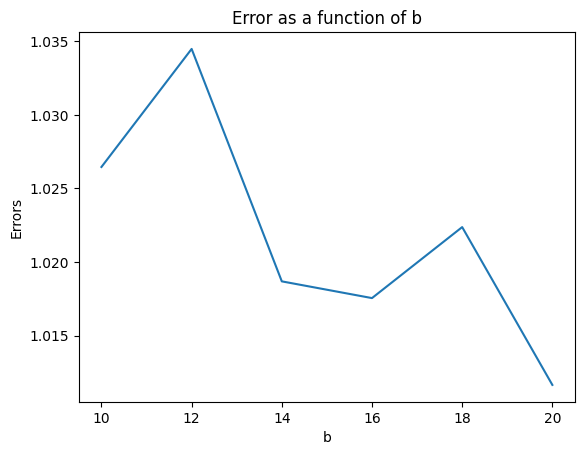

In [45]:
# TODO: YOUR CODE HERE
def evaluate(lsh, query_points, true_neighbours, num_neighbours ):
  #Use lsh to search on all the query_vectors and compare it with true_neighbours
  lsh_dist = []
  for i in range(query_points.shape[0]):
    query_vector = query_points[i,:]
    lsh_dist.append(lsh.lsh_search(query_vector, num_neighbours=num_neighbours)[1])
  return lsh_error(lsh_dist, true_neighbours)

b_list = list(range(10,21,2))
b_errors = []

for b in b_list:
  lsh = my_LSH(dataset , n_rows=24 , n_bands=b)
  b_errors.append(evaluate(lsh, query_points, linear_dist, 3))

plt.plot(b_list, b_errors)
plt.title("Error as a function of b")
plt.xlabel("b")
plt.ylabel("Errors")

plt.show()



Comment: As we increase number of bands, probability of an image being a candidate increases; so, we are missing less similar images (Decrease in Error).

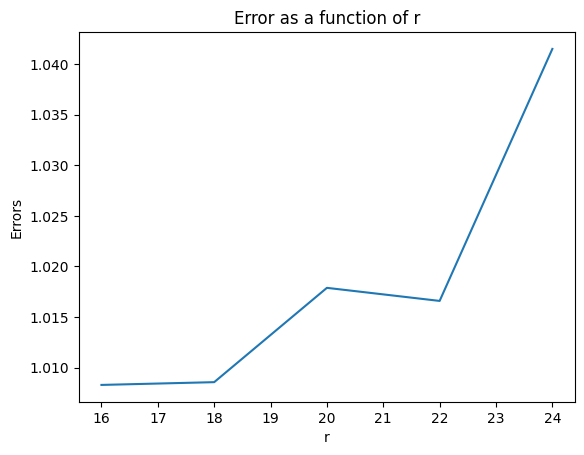

In [35]:
r_list = list(range(16,25,2))
r_errors = []

for r in r_list:
  lsh = my_LSH(dataset, n_rows=r, n_bands=10)
  r_errors.append(evaluate(lsh, query_points, linear_dist, 3))

plt.plot(r_list, r_errors)
plt.title("Error as a function of r")
plt.xlabel("r")
plt.ylabel("Errors")

plt.show()



Comment: As we increase number of rows, probability of an image being a candidate decreases; so, we are missing more similar images (Increase in Error).

### e) Plot 10 nearest neighbours

In [40]:
# TODO: YOUR CODE HERE
query_vector = data[99,:]
A = np.delete(data, 99, axis=0) #Delete query vector from the dataset we are searching on (A)

lsh = my_LSH(A , n_rows=24 , n_bands=10 )
top10_lsh = lsh.lsh_search(query_vector)[0]
top10_linear = linear_search(A, query_vector, 10)[0]

print("Query Image: ")
plot(data,[99], "Query")
print("========================================")
print("Top 10 From LSH")
plot(A, top10_lsh, "LSH")
print("========================================")
print("Top 10 From Linear Search")
plot(A, top10_linear, "Linear")




Query Image: 


Top 10 From LSH


Top 10 From Linear Search


Explanation: The images from linear search are visually more similar to the Query image than images from LSH. There are some images from LSH which are quite similar to the query image and are a subset of images from Linear search; however, there are also some images from LSH which are fairly different from the query image.

### f) Change hash function

In [48]:
# TODO: YOUR CODE HERE
class cosine_LSH(my_LSH):
    def create_band_function(self, random_vectors):

        def band_function(v):
            #for each random vector, compute the dot product with v
            #if dot product >= 0, 1 is added to boolarray
            #otherwise, 0 is added to boolarray
            #Finally we have a string of "1001010..." with n_rows characters
            boolarray = [np.dot(rv,v) >= 0 for rv in random_vectors]
            return "".join(map(str, map(int, boolarray)))
        return band_function

    def create_bands(self, num_dimensions=400):
        bands = []
        for i in range(self.n_bands): #For each band
            random_vectors = []
            for r in range(self.n_rows): #Generate n_rows random vectors
              random_vector = np.random.choice([-1, 1], size=num_dimensions) #random vector with 1,-1 as elements
              random_vectors.append(random_vector)
            bands.append(self.create_band_function(random_vectors))
        return bands

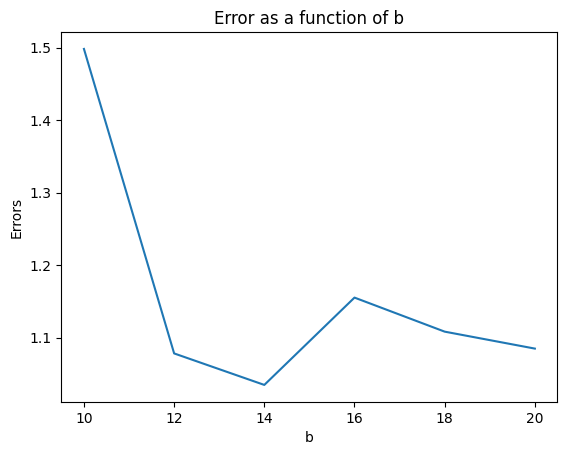

In [49]:
b_list = list(range(10,21,2))
b_errors = []

for b in b_list:
  lsh = cosine_LSH(dataset , n_rows=24 , n_bands=b)
  b_errors.append(evaluate(lsh, query_points, linear_dist, 3))

plt.plot(b_list, b_errors)
plt.title("Error as a function of b")
plt.xlabel("b")
plt.ylabel("Errors")

plt.show()


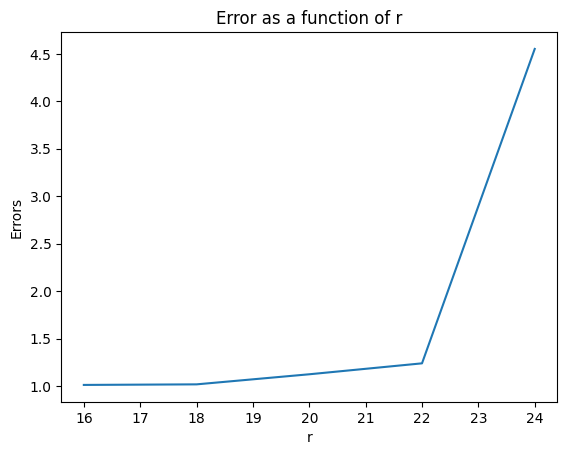

In [50]:
r_list = list(range(16,25,2))
r_errors = []

for r in r_list:
  lsh = cosine_LSH(dataset, n_rows=r, n_bands=10)
  r_errors.append(evaluate(lsh, query_points, linear_dist, 3))

plt.plot(r_list, r_errors)
plt.title("Error as a function of r")
plt.xlabel("r")
plt.ylabel("Errors")

plt.show()



Explanation: It takes alot more time to execute part d compared to the original hash function. We see the same trend as in part d of the original hash function, but the difference in error of each r & b is a lot larger.